In [2]:
import pandas as pd
import numpy as np
from utils import *
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.manifold import TSNE
from pprint import pprint
from time import time as time_actual
import math

In [3]:
RANDOM_STATE=42

### Data loading

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data('train.csv')


x shape   y shape
(8968, 6) (8968,)
(1500, 6) (1500,)
(1500, 6) (1500,)


In [26]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

Quality    4648
Spam       4319
Name: Type, dtype: int64
Quality    759
Spam       741
Name: Type, dtype: int64
Spam       755
Quality    745
Name: Type, dtype: int64


In [5]:
x_train["location"] = x_train.location.fillna("")
cols = ['following', 'followers', 'actions']
x_train_imp, imputer = impute_dataframe(x_train, cols, verbose=True)
x_train_imp = x_train_imp.dropna()
print(True in x_train_imp.isna())

(8968, 6) (8968, 6)
NAN Counts:
 Tweet         0
following     0
followers     0
actions       0
is_retweet    1
location      0
dtype: int64
False


In [6]:
x_val["location"] = x_val.location.fillna("")
x_val_imp_intermediate = pd.DataFrame(imputer.transform(x_val[cols]), columns=imputer.feature_names_in_, index=x_val.index)
x_val_imp = x_val.copy()
x_val_imp[cols] = x_val_imp_intermediate[cols]
print(x_val_imp.shape)
print(True in x_val_imp.isna())
x_val_imp.head()

(1500, 6)
False


Tweet  following  followers  \
0  #MyEmmyNominationWouldBe  for drinking water. ...    11102.0    17447.0   
1  "(with all these make-up and clothes) I feel l...        0.0        0.0   
2  I just finished 1h:29m:36s of doing weight tra...        0.0        0.0   
3                                   notice me senpai        0.0        0.0   
4                               IM LITERALLY SO LOST        0.0        0.0   

      actions is_retweet                  location  
0  7650.00000        1.0             York, England  
1  7232.71468        0.0                            
2     0.00000        0.0  ÜT: 18.438504,-66.505538  
3     0.00000        0.0                            
4     0.00000        0.0                @moontosUp

In [7]:
x_test["location"] = x_test.location.fillna("")
x_test_imp_intermediate = pd.DataFrame(imputer.transform(x_test[cols]), columns=imputer.feature_names_in_, index=x_test.index)
x_test_imp = x_test.copy()
x_test_imp[cols] = x_test_imp_intermediate[cols]
print(x_test_imp.shape)
print(True in x_test_imp.isna())
x_test_imp.head()

(1500, 6)
False


Tweet  following  followers  \
0  Student in Claremont posts controversial ad fo...    10235.0    12150.0   
1   David Castro via SnapChat http://fb.me/3D1q3fZ7S        0.0        0.0   
2  #IS claims capture of Nahdah and Mathmanah vil...     4916.0    24940.0   
3  Victory! Coalition of Tribes and Environmental...      832.0      696.0   
4  RT iswdopn: Marr2rrCarr FoxNews KatTimpf CNN I...       38.0        7.0   

   actions is_retweet                        location  
0  14844.0        0.0      Fredericton, New Brunswick  
1      0.0        0.0                    New York, NY  
2   8906.0        0.0                  United Kingdom  
3   1493.0        1.0      Em algum lugar do mundo  🌎  
4   1732.0        0.0  home is where the heart is  ❤️

In [8]:
y_train = y_train[y_train.index.intersection(x_train_imp.index)]
y_val = y_val[y_val.index.intersection(x_val_imp.index)]
y_test = y_test[y_test.index.intersection(x_test_imp.index)]

In [9]:
x_train_std, x_val_std, x_test_std = standardise(x_train_imp, x_val_imp, x_test_imp, cols)

### Hyper-parameter search

In [11]:
# PredefinedSplit
train_array = np.ones(x_train_std.shape[0])
train_array = train_array * -1
val_array = np.zeros(x_val_std.shape[0])
test_fold=np.concatenate((train_array, val_array))
print(test_fold)
print(test_fold.shape)
x_train_val = pd.concat((x_train_std, x_val_std))
print(x_train_val.shape)
y_train_val = pd.concat((y_train, y_val))
print(y_train_val.shape)

[-1. -1. -1. ...  0.  0.  0.]
(10467,)
(10467, 6)
(10467,)


In [12]:
# Sanity checking PredefinedSplit
ps=PredefinedSplit(test_fold)
for train_index, test_index in ps.split():
     print("TRAIN:", train_index, "TEST:", test_index)
     train_x, test_x = x_train_val.iloc[train_index,:], x_train_val.iloc[test_index,:]
     train_y, test_y = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
print(train_x.shape)
print(test_x.shape)
print(x_train.shape)
print(x_val.shape)
print(np.array_equal(train_x,x_train_std))
print(np.array_equal(test_x,x_val_std))
print(np.array_equal(train_y,y_train))
print(np.array_equal(test_y,y_val))

TRAIN: [   0    1    2 ... 8964 8965 8966] TEST: [ 8967  8968  8969 ... 10464 10465 10466]
(8967, 6)
(1500, 6)
(8968, 6)
(1500, 6)
True
True
True
True


In [13]:
# Define a pipeline combining a text feature extractor with a simple classifier
# How to grid search over multiple classifiers or pipelines: https://stackoverflow.com/questions/23045318/grid-search-over-multiple-classifiers
# Why the parameters are oddly named: https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier
# pipeline_count = Pipeline(
#     [
#         ("vect", ColumnTransformer([
#             ('tweet', CountVectorizer(), 'Tweet'),
#             ('location', CountVectorizer(), 'location')
#         ], remainder='passthrough')),
#         ("clf", SVC()),
#     ]
# )

pipeline_tfidf = Pipeline(
    [
        ("tfidf", ColumnTransformer([
            ('tweet', TfidfVectorizer(), 'Tweet'),
            ('location', TfidfVectorizer(), 'location')
        ], remainder='passthrough')),
        ("clf", SVC()),
    ]
)

# grid search parameters
max_df = (0.125, 0.25, 0.5, 0.75, 1.0)
min_df = (0.0001, 0.005, 0.001, 0.05, 0.01, int(1))
# ngram_range = ((1, 1), (1, 2))
c = (0.001, 0.01, 0.1, 1, 10, 100, 1000)
class_weight = (None, "balanced")
gamma = ('scale', 'auto', 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001)
degree = (3, 4, 5, 6)
token_pattern = (r"[a-z0-9#@\*'\":\-\n%,\.;]+", r"(?u)\b\w\w+\b")

# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
# parameters_count = [{
#     "vect__tweet__max_df": max_df,
#     "vect__tweet__min_df": min_df,
#     # "vect__tweet__ngram_range": ngram_range,  # unigrams or bigrams
#     "vect__tweet__token_pattern": token_pattern,
#     "vect__location__max_df": max_df,
#     "vect__location__min_df": min_df,
#     # "vect__location__ngram_range": ngram_range,  # unigrams or bigrams
#     "vect__location__token_pattern": token_pattern#,
#     # "clf__C": c,
#     # "clf__kernel": ["linear"],
#     # "clf__class_weight": class_weight
# }]
# },
# {
#     "vect__tweet__max_df": max_df,
#     "vect__tweet__min_df": min_df,
#     "vect__tweet__ngram_range": ngram_range,  # unigrams or bigrams
#     "vect__tweet__token_pattern": token_pattern,
#     "vect__location__token_pattern": token_pattern,
#     "vect__location__max_df": max_df,
#     "vect__location__min_df": min_df,
#     "vect__location__ngram_range": ngram_range,  # unigrams or bigrams
#     "clf__C": c,
#     'clf__gamma': gamma,
#     "clf__kernel": ["rbf"],
#     "clf__class_weight": class_weight
#     },
# {
#     "vect__tweet__max_df": max_df,
#     "vect__tweet__min_df": min_df,
#     "vect__tweet__ngram_range": ngram_range,  # unigrams or bigrams
#     "vect__tweet__token_pattern": token_pattern,
#     "vect__location__token_pattern": token_pattern,
#     "vect__location__max_df": max_df,
#     "vect__location__min_df": min_df,
#     "vect__location__ngram_range": ngram_range,  # unigrams or bigrams
#     "clf__C": c,
#     'clf__degree': degree,
#     "clf__kernel": ["poly"],
#     "clf__class_weight": class_weight
# }]

In [14]:
use_idf = (True, False)
norm = ('l1', 'l2')

parameters_tfidf = [{
    "tfidf__tweet__max_df": max_df,
    "tfidf__tweet__min_df": min_df,
    'tfidf__tweet__use_idf': use_idf,
    'tfidf__tweet__norm': norm,
    # "tfidf__tweet__ngram_range": ngram_range,  # unigrams or bigrams
    "tfidf__tweet__token_pattern": token_pattern,
    "tfidf__location__token_pattern": token_pattern,
    "tfidf__location__max_df": max_df,
    "tfidf__location__min_df": min_df,
    'tfidf__location__use_idf': use_idf,
    'tfidf__location__norm': norm,
    # "tfidf__location__ngram_range": ngram_range#,  # unigrams or bigrams
}]
#     "clf__C": c,
#     "clf__kernel": ["linear"],
#     "clf__class_weight": class_weight
# },
# {
#     "tfidf__tweet__max_df": max_df,
#     "tfidf__tweet__min_df": min_df,
#     'tfidf__tweet__use_idf': use_idf,
#     'tfidf__tweet__norm': norm,
#     "tfidf__tweet__ngram_range": ngram_range,  # unigrams or bigrams
#     "tfidf__tweet__token_pattern": token_pattern,
#     "tfidf__location__token_pattern": token_pattern,
#     "tfidf__location__max_df": max_df,
#     "tfidf__location__min_df": min_df,
#     'tfidf__location__use_idf': use_idf,
#     'tfidf__location__norm': norm,
#     "tfidf__location__ngram_range": ngram_range,  # unigrams or bigrams
#     "clf__C": c,
#     'clf__gamma': gamma,
#     "clf__kernel": ["rbf"],
#     "clf__class_weight": class_weight
# },
# {
#     "tfidf__tweet__max_df": max_df,
#     "tfidf__tweet__min_df": min_df,
#     'tfidf__tweet__use_idf': use_idf,
#     'tfidf__tweet__norm': norm,
#     "tfidf__tweet__ngram_range": ngram_range,  # unigrams or bigrams
#     "tfidf__tweet__token_pattern": token_pattern,
#     "tfidf__location__token_pattern": token_pattern,
#     "tfidf__location__max_df": max_df,um
#     "tfidf__location__min_df": min_df,
#     'tfidf__location__use_idf': use_idf,
#     'tfidf__location__norm': norm,
#     "tfidf__location__ngram_range": ngram_range,  # unigrams or bigrams
#     "clf__C": c,
#     'clf__degree': degree,
#     "clf__kernel": ["poly"],
#     "clf__class_weight": class_weight
# }]

# Find the best parameters for both the feature extraction and the
# classifier
ensemble_clf=[pipeline_count, pipeline_tfidf]
params_list=[parameters_count, parameters_tfidf]
model_log=["_count", "_tfidf"]
for i in range(len(ensemble_clf)):
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in ensemble_clf[i].steps])
  print("parameters:")
  pprint(params_list[i])
  start_time = time()
  Grid=grid_search = GridSearchCV(estimator=ensemble_clf[i], param_grid=params_list[i], n_jobs=-1, cv=PredefinedSplit(test_fold)).fit(x_train_val, y_train_val)
  end_time = time()
  time = end_time - start_time
  print("done in %0.3fs" % (time))
  globals()['Grid%s' % model_log[i]]=Grid
  globals()['Grid_time%s' % model_log[i]]=time

In [ ]:
def print_best(search, parameters):
  print("Best score: %0.3f" % search.best_score_)
  best_parameters = search.best_estimator_.get_params()
  for param_name in sorted(parameters[0].keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
print_best(Grid_count, parameters_count)
print_best(Grid_tfidf, parameters_tfidf)

Best score: 0.955
	vect__location__max_df: 0.25
	vect__location__min_df: 0.005
	vect__location__token_pattern: '(?u)\\b\\w\\w+\\b'
	vect__tweet__max_df: 0.5
	vect__tweet__min_df: 0.001
	vect__tweet__token_pattern: '(?u)\\b\\w\\w+\\b'
Best score: 0.970
	tfidf__location__max_df: 0.25
	tfidf__location__min_df: 0.005
	tfidf__location__norm: 'l1'
	tfidf__location__token_pattern: '(?u)\\b\\w\\w+\\b'
	tfidf__location__use_idf: True
	tfidf__tweet__max_df: 0.5
	tfidf__tweet__min_df: 0.005
	tfidf__tweet__norm: 'l2'
	tfidf__tweet__token_pattern: '(?u)\\b\\w\\w+\\b'
	tfidf__tweet__use_idf: True


In [ ]:
def get_best(search, parameters):
    results = dict()
#   print("Best score: %0.3f" % search.best_score_)
    best_parameters = search.best_estimator_.get_params()
    for param_name in sorted(parameters[0].keys()):
        results[param_name] = best_parameters[param_name]
    return results

In [ ]:
# SVM search
best_parameters_tfidf = get_best(Grid_tfidf, parameters_tfidf)
parameters_svm = [{
    # "tfidf__tweet__max_df": [best_parameters_tfidf["tfidf__tweet__max_df"]],
    # "tfidf__tweet__min_df": [best_parameters_tfidf["tfidf__tweet__min_df"]],
    # 'tfidf__tweet__use_idf': [best_parameters_tfidf['tfidf__tweet__use_idf']],
    # 'tfidf__tweet__norm': [best_parameters_tfidf['tfidf__tweet__norm']],
    # "tfidf__tweet__token_pattern": [best_parameters_tfidf["tfidf__tweet__token_pattern"]],
    # "tfidf__location__token_pattern": [best_parameters_tfidf["tfidf__location__token_pattern"]],
    # "tfidf__location__max_df": [best_parameters_tfidf["tfidf__location__max_df"]],
    # "tfidf__location__min_df": [best_parameters_tfidf["tfidf__location__min_df"]],
    # 'tfidf__location__use_idf': [best_parameters_tfidf['tfidf__location__use_idf']],
    # 'tfidf__location__norm': [best_parameters_tfidf['tfidf__location__norm']],
    "C": c,
    "kernel": ["linear"],
    "class_weight": class_weight
},
{
    # "tfidf__tweet__max_df": [best_parameters_tfidf["tfidf__tweet__max_df"]],
    # "tfidf__tweet__min_df": [best_parameters_tfidf["tfidf__tweet__min_df"]],
    # 'tfidf__tweet__use_idf': [best_parameters_tfidf['tfidf__tweet__use_idf']],
    # 'tfidf__tweet__norm': [best_parameters_tfidf['tfidf__tweet__norm']],
    # "tfidf__tweet__token_pattern": [best_parameters_tfidf["tfidf__tweet__token_pattern"]],
    # "tfidf__location__token_pattern": [best_parameters_tfidf["tfidf__location__token_pattern"]],
    # "tfidf__location__max_df": [best_parameters_tfidf["tfidf__location__max_df"]],
    # "tfidf__location__min_df": [best_parameters_tfidf["tfidf__location__min_df"]],
    # 'tfidf__location__use_idf': [best_parameters_tfidf['tfidf__location__use_idf']],
    # 'tfidf__location__norm': [best_parameters_tfidf['tfidf__location__norm']],
    "C": c,
    'gamma': gamma,
    "kernel": ["rbf"],
    "class_weight": class_weight
},
{
    # "tfidf__tweet__max_df": [best_parameters_tfidf["tfidf__tweet__max_df"]],
    # "tfidf__tweet__min_df": [best_parameters_tfidf["tfidf__tweet__min_df"]],
    # 'tfidf__tweet__use_idf': [best_parameters_tfidf['tfidf__tweet__use_idf']],
    # 'tfidf__tweet__norm': [best_parameters_tfidf['tfidf__tweet__norm']],
    # "tfidf__tweet__token_pattern": [best_parameters_tfidf["tfidf__tweet__token_pattern"]],
    # "tfidf__location__token_pattern": [best_parameters_tfidf["tfidf__location__token_pattern"]],
    # "tfidf__location__max_df": [best_parameters_tfidf["tfidf__location__max_df"]],
    # "tfidf__location__min_df": [best_parameters_tfidf["tfidf__location__min_df"]],
    # 'tfidf__location__use_idf': [best_parameters_tfidf['tfidf__location__use_idf']],
    # 'tfidf__location__norm': [best_parameters_tfidf['tfidf__location__norm']],
    "C": c,
    'degree': degree,
    "kernel": ["poly"],
    "class_weight": class_weight
}]

In [ ]:
# Consider just creating one TF-IDF object, transforming beforehand, then gridsearching. Otherwise, good luck.
# Also drop some of the SVM things in scope.
tfidf = ColumnTransformer([
            ('tweet', TfidfVectorizer(), 'Tweet'),
            ('location', TfidfVectorizer(), 'location')
        ], remainder='passthrough')

tfidf_params = {"tweet__max_df": best_parameters_tfidf["tfidf__tweet__max_df"],
    "tweet__min_df": best_parameters_tfidf["tfidf__tweet__min_df"],
    'tweet__use_idf': best_parameters_tfidf['tfidf__tweet__use_idf'],
    'tweet__norm': best_parameters_tfidf['tfidf__tweet__norm'],
    "tweet__token_pattern": best_parameters_tfidf["tfidf__tweet__token_pattern"],
    "location__token_pattern": best_parameters_tfidf["tfidf__location__token_pattern"],
    "location__max_df": best_parameters_tfidf["tfidf__location__max_df"],
    "location__min_df": best_parameters_tfidf["tfidf__location__min_df"],
    'location__use_idf': best_parameters_tfidf['tfidf__location__use_idf'],
    'location__norm': best_parameters_tfidf['tfidf__location__norm']}

tfidf = tfidf.set_params(**tfidf_params)
tfidf = tfidf.fit(x_train_std)
x_train_val_tfidf = tfidf.transform(x_train_val)

svm = SVC()

start_time = time
grid_search = GridSearchCV(estimator=svm, param_grid=parameters_svm, n_jobs=-1, verbose=3, cv=PredefinedSplit(test_fold)).fit(x_train_val_tfidf, y_train_val)
end_time = time
time = end_time - start_time
print("SVM + BoW (TF-IDF) grid search completed in {:0.3f} s".format(time))

NameError: name 'best_parameters_tfidf' is not defined

In [ ]:
def print_best_svm(search, parameters):
  print("Best score: %0.3f" % search.best_score_)
  best_parameters = search.best_estimator_.get_params()
  for param_name in sorted(parameters[1].keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
print_best_svm(grid_search, parameters_svm)

Best score: 0.970
	C: 1
	class_weight: None
	gamma: 'scale'
	kernel: 'rbf'


In [ ]:
print(grid_search.cv_results_)

{'mean_fit_time': array([ 13.56215286,  15.60937691,   8.31726265,   9.26785588,
         5.11338472,   4.82531571,   3.21680951,   3.32660794,
         4.56653023,   4.54508424,  14.27196407,  13.90138173,
       122.60906219, 128.02717304,  17.26438069,  16.67123723,
        15.1264782 ,  13.35831642,  13.20905948,  15.53209472,
        17.88024354,  17.14127922,  16.58056259,  17.86353421,
        18.32471585,  17.57335734,  20.10407424,  20.85465646,
        21.90391564,  18.45786047,  20.37109756,  21.17333007,
        16.36333251,  16.80561209,   9.70246363,  18.23688102,
        15.82325506,  14.15706706,  15.87729263,  14.98256397,
        11.50855541,  14.49733734,  13.81502271,  13.75118804,
         9.48044896,  15.4072299 ,  16.6431849 ,  18.15984511,
        17.28682017,  13.49683952,  11.47098994,  16.37132907,
        16.13747907,  16.9928298 ,   4.97202921,  13.49485612,
        15.12234354,  13.36260009,  13.93575859,   7.47765923,
         5.90477037,   9.96939135,  1

In [ ]:
best_systems = np.where(grid_search.cv_results_['rank_test_score'] == 1)
print(best_systems[0])
for idx in best_systems[0]:
    params = grid_search.cv_results_['params'][idx]
    print(params)

[74 84]
{'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
savedata(Grid_count, "gridcount")
savedata(Grid_tfidf, "gridtfidf")
savedata(grid_search, "gridsvm")

NameError: name 'Grid_count' is not defined

### Training

In [10]:
grid_search = loaddata("gridsvm")
tfidf_params = loaddata("gridtfidf")

In [11]:
def get_best_replace(search, parameters):
    results = dict()
#   print("Best score: %0.3f" % search.best_score_)
    best_parameters = search.best_estimator_.get_params()
    for param_name in sorted(parameters[0].keys()):
        results[param_name.replace("tfidf__","")] = best_parameters[param_name]
    return results

In [12]:
max_df = (0.125, 0.25, 0.5, 0.75, 1.0)
min_df = (0.0001, 0.005, 0.001, 0.05, 0.01, int(1))
# ngram_range = ((1, 1), (1, 2))
c = (0.001, 0.01, 0.1, 1, 10, 100, 1000)
token_pattern = (r"[a-z0-9#@\*'\":\-\n%,\.;]+", r"(?u)\b\w\w+\b")
use_idf = (True, False)
norm = ('l1', 'l2')

parameters_tfidf = [{
    "tfidf__tweet__max_df": max_df,
    "tfidf__tweet__min_df": min_df,
    'tfidf__tweet__use_idf': use_idf,
    'tfidf__tweet__norm': norm,
    # "tfidf__tweet__ngram_range": ngram_range,  # unigrams or bigrams
    "tfidf__tweet__token_pattern": token_pattern,
    "tfidf__location__token_pattern": token_pattern,
    "tfidf__location__max_df": max_df,
    "tfidf__location__min_df": min_df,
    'tfidf__location__use_idf': use_idf,
    'tfidf__location__norm': norm,
    # "tfidf__location__ngram_range": ngram_range#,  # unigrams or bigrams
}]

### Experimenting with no location on SVM

In [15]:
params = get_best_replace(tfidf_params, parameters_tfidf)

In [27]:
tfidf = ColumnTransformer([
            ('tweet', TfidfVectorizer(), 'Tweet'),
        ], remainder='passthrough')

tweet_params = {key: params[key] for key in params.keys() if key.startswith("tweet__")}

In [31]:
svm = SVC()
svm = svm.set_params(**grid_search.cv_results_['params'][84])
tfidf = tfidf.set_params(**tweet_params)
start_time = time_actual()
tfidf = tfidf.fit(x_train_std.drop("location", axis=1))
end_time = time_actual()
time = end_time - start_time
print("BoW (TF-IDF) trained in {:0.3f} s".format(time))

BoW (TF-IDF) trained in 0.146 s


In [32]:
start_time = time_actual()
x_train_tfidf = tfidf.transform(x_train_std.drop("location", axis=1))
end_time = time_actual()
time = end_time - start_time
print("BoW (TF-IDF) transformed train set in {:0.3f} s".format(time))

BoW (TF-IDF) transformed train set in 0.091 s


In [33]:
start_time = time_actual()
svm = svm.fit(x_train_tfidf, y_train)
end_time = time_actual()
time = end_time - start_time
print("SVM trained in {:0.3f} s".format(time))

SVM trained in 1.568 s


In [34]:
start_time = time_actual()
x_test_tfidf = tfidf.transform(x_test_std.drop("location", axis=1))
end_time = time_actual()
time = end_time - start_time
print("BoW (TF-IDF) transformed test set in {:0.3f} s".format(time))

BoW (TF-IDF) transformed test set in 0.022 s


Inference time for test set is 0.180 s
              precision    recall  f1-score   support

     Quality       0.94      0.97      0.95       745
        Spam       0.97      0.93      0.95       755

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



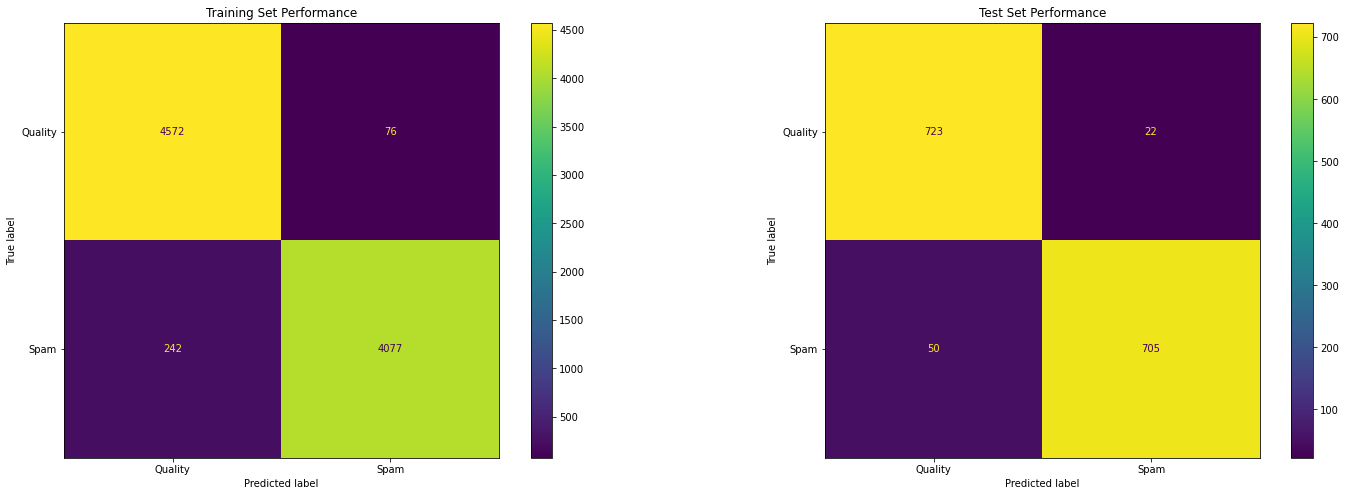

In [35]:
eval_model(svm, x_train_tfidf, y_train, x_test_tfidf, y_test)

### Actual tests

In [13]:
tfidf = ColumnTransformer([
            ('tweet', TfidfVectorizer(), 'Tweet'),
            ('location', TfidfVectorizer(), 'location')
        ], remainder='passthrough')

svm = SVC()
svm = svm.set_params(**grid_search.cv_results_['params'][84])
tfidf = tfidf.set_params(**get_best_replace(tfidf_params, parameters_tfidf))
start_time = time_actual()
tfidf = tfidf.fit(x_train_std)
end_time = time_actual()
time = end_time - start_time
print("BoW (TF-IDF) trained in {:0.3f} s".format(time))

BoW (TF-IDF) trained in 0.169 s


In [14]:
start_time = time_actual()
x_train_tfidf = tfidf.transform(x_train_std)
end_time = time_actual()
time = end_time - start_time
print("BoW (TF-IDF) transformed train set in {:0.3f} s".format(time))

BoW (TF-IDF) transformed train set in 0.216 s


In [15]:
start_time = time_actual()
svm = svm.fit(x_train_tfidf, y_train)
end_time = time_actual()
time = end_time - start_time
print("SVM trained in {:0.3f} s".format(time))

SVM trained in 1.858 s


In [16]:
start_time = time_actual()
x_test_tfidf = tfidf.transform(x_test_std)
end_time = time_actual()
time = end_time - start_time
print("BoW (TF-IDF) transformed test set in {:0.3f} s".format(time))

BoW (TF-IDF) transformed test set in 0.079 s


In [17]:
savedata(svm.predict(x_test_tfidf), "svm_preds")

Inference time for test set is 0.178 s
              precision    recall  f1-score   support

     Quality       0.95      0.98      0.96       745
        Spam       0.98      0.95      0.96       755

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



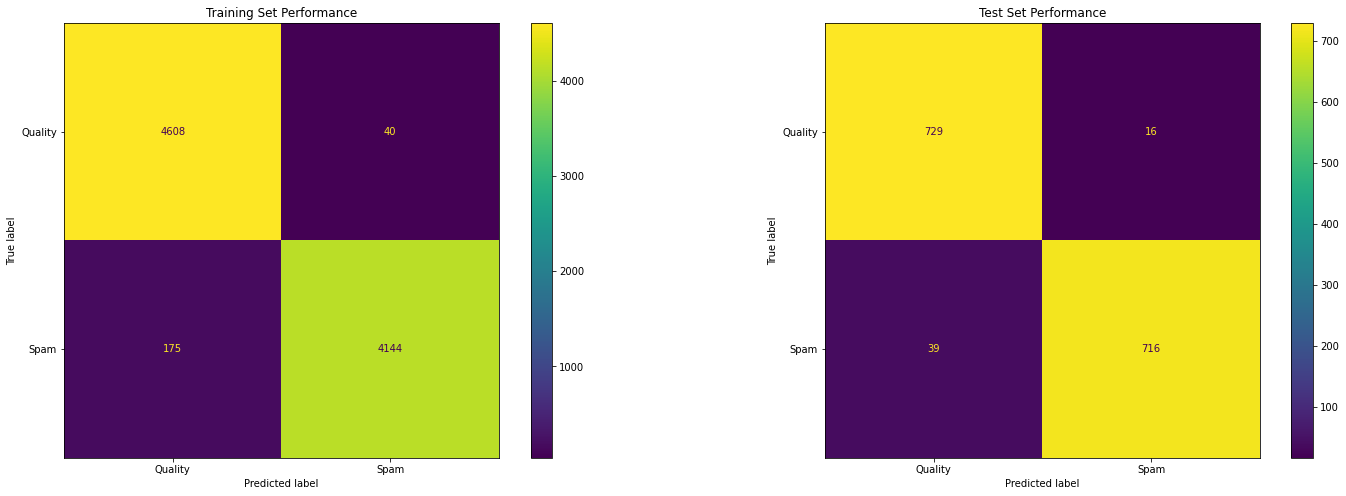

In [16]:
eval_model(svm, x_train_tfidf, y_train, x_test_tfidf, y_test)

### Analysis

In [ ]:
svm._gamma

0.2220018930623776

### Pulling out false positives and negative indices

In [16]:
counter = 0
false_negatives = []
false_positives = []
correct = []
for input, prediction, label in zip(range(x_test_tfidf.shape[0]), svm.predict(x_test_tfidf), y_test):
  if prediction != label:
    print(input, 'has been classified as ', prediction, 'and should be ', label) 
    counter += 1
    if prediction == "Quality":
      false_negatives.append(input)
    else:
      false_positives.append(input)
  else:
    correct.append(input)
print(f"{counter} incorrect predictions, {len(false_negatives)} false negatives")

4 has been classified as  Quality and should be  Spam
10 has been classified as  Quality and should be  Spam
14 has been classified as  Spam and should be  Quality
47 has been classified as  Spam and should be  Quality
82 has been classified as  Quality and should be  Spam
94 has been classified as  Quality and should be  Spam
113 has been classified as  Quality and should be  Spam
210 has been classified as  Quality and should be  Spam
228 has been classified as  Quality and should be  Spam
257 has been classified as  Spam and should be  Quality
342 has been classified as  Spam and should be  Quality
346 has been classified as  Spam and should be  Quality
353 has been classified as  Spam and should be  Quality
406 has been classified as  Quality and should be  Spam
435 has been classified as  Spam and should be  Quality
457 has been classified as  Quality and should be  Spam
474 has been classified as  Quality and should be  Spam
479 has been classified as  Quality and should be  Spam

### Getting the vocabulary of words

In [17]:
tweet_vocab = tfidf.named_transformers_["tweet"].vocabulary_
tweet_stop = tfidf.named_transformers_["tweet"].stop_words_
loc_vocab = tfidf.named_transformers_["location"].vocabulary_
loc_stop = tfidf.named_transformers_["location"].stop_words_

In [22]:
print(len(tweet_vocab))
print(len(tweet_stop))
print(len(loc_vocab))
print(len(loc_stop))

276
27618
36
2841


### Frequencies and histogram intersects

In [23]:
### Sum of frequencies for training set
# Pull out words we found, check their freqs
word_tfidf_train, spam_words_train, quality_words_train = find_words_sum(tfidf, x_train_tfidf, y_train, only_tweets=True)
sorted_quality_words_train, sorted_spam_words_train = sort_spam_quality(spam_words_train, quality_words_train)
# pprint(sorted_quality_words_train[0:10])
# print()
# pprint(sorted_spam_words_train[0:10])


In [24]:
### Histogram intersections
# Sense check order of words
spam_words_train_only = [word for word in spam_words_train.keys()]
quality_words_train_only = [word for word in quality_words_train.keys()]
spam_words_train_only == quality_words_train_only
spam_freq_train = np.array([spam_words_train[word] for word in spam_words_train.keys()])
quality_freq_train = np.array([quality_words_train[word] for word in quality_words_train.keys()])
# Sense check the values match across this and the old dict
for idx, word in enumerate(spam_words_train.keys()):
    if spam_freq_train[idx] != spam_words_train[word]:
        print("WARNING! Not equal.")
# Sense check the values match across this and the old dict
for idx, word in enumerate(quality_words_train.keys()):
    if quality_freq_train[idx] != quality_words_train[word]:
        print("WARNING! Not equal.")
spam_freq_train_norm = normalise_histogram(spam_freq_train)
quality_freq_train_norm = normalise_histogram(quality_freq_train)
print("Spam v Quality for train: {}".format(histogram_intersection(spam_freq_train_norm, quality_freq_train_norm)))


Spam v Quality for train: 0.5874856839372968


In [25]:
### Freq sum for test set
# Pull out words we found, check their freqs on the test set
word_tfidf_test, spam_words_test, quality_words_test = find_words_sum(tfidf, x_test_tfidf, y_test)

sorted_quality_test_words, sorted_spam_test_words = sort_spam_quality(spam_words_test, quality_words_test)
# pprint(sorted_quality_test_words[0:10])
# print()
# pprint(sorted_spam_test_words[0:10])


In [26]:
### Hist intersect for test set

# Sense check order of words
spam_words_test_only = [word for word in spam_words_test.keys()]
quality_words_test_only = [word for word in quality_words_test.keys()]
spam_words_test_only == quality_words_test_only
spam_freq_test = np.array([spam_words_test[word] for word in spam_words_test.keys()])
quality_freq_test = np.array([quality_words_test[word] for word in quality_words_test.keys()])
# Sense check the values match across this and the old dict
for idx, word in enumerate(spam_words_test.keys()):
    if spam_freq_test[idx] != spam_words_test[word]:
        print("WARNING! Not equal.")
# Sense check the values match across this and the old dict
for idx, word in enumerate(quality_words_test.keys()):
    if quality_freq_test[idx] != quality_words_test[word]:
        print("WARNING! Not equal.")
spam_freq_test_norm = normalise_histogram(spam_freq_test)
quality_freq_test_norm = normalise_histogram(quality_freq_test)
print("Spam v Quality for test: {}".format(histogram_intersection(spam_freq_test_norm, quality_freq_test_norm)))
print("Spam v Spam: {}".format(histogram_intersection(spam_freq_test_norm, spam_freq_train_norm)))
print("Quality v Quality: {}".format(histogram_intersection(quality_freq_train_norm, quality_freq_test_norm)))

Spam v Quality for test: 0.5074501023419579
Spam v Spam: 0.7292874812813066
Quality v Quality: 0.7761205412223819


### Analysing false positives and negatives by word counts and frequencies

In [27]:
for idx in false_negatives:
    print(x_test_std.iloc[idx, :])

Tweet         RT iswdopn: Marr2rrCarr FoxNews KatTimpf CNN I...
following                                             -0.157268
followers                                             -0.092857
actions                                               -0.384205
is_retweet                                                  0.0
location                         home is where the heart is  ❤️
Name: 4, dtype: object
Tweet         Quebec As Folk #MakeTVShowsCanadian @midnight
following                                          0.000087
followers                                         -0.091953
actions                                           -0.140022
is_retweet                                              0.0
location                                  Near Worthing, UK
Name: 10, dtype: object
Tweet         #IAmNotThePresidentBecause even @BarackObama i...
following                                              0.168872
followers                                             -0.088778
actions          

In [28]:
for idx in false_positives:
    print(x_test_std.iloc[idx, :])

Tweet         "I'd rather regret the things that I have done...
following                                             -0.158538
followers                                             -0.092859
actions                                               -0.505179
is_retweet                                                  0.0
location                               United States of America
Name: 14, dtype: object
Tweet         Gm to you too and everything is going well for...
following                                              0.306039
followers                                             -0.089156
actions                                                    -0.0
is_retweet                                                  1.0
location                              I N T E R N A T I O N A L
Name: 47, dtype: object
Tweet         $LUV - Creative Planning Has $5,572,000 Stake ...
following                                                  -0.0
followers                                             -0

In [29]:
# Print how many words were in the vocabulary
# Based on train set.
print(num_matching_words(x_test_std, false_negatives, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_vocab, verbose=True, spam_count_dict=spam_words_train, quality_count_dict=quality_words_train))

Document contents:
RT iswdopn: Marr2rrCarr FoxNews KatTimpf CNN It's getting scarier by the minute isn't it

Pattern found the following words:
['rt', 'iswdopn', 'marr2rrcarr', 'foxnews', 'kattimpf', 'cnn', 'it', 'getting', 'scarier', 'by', 'the', 'minute', 'isn', 'it']

{'it', 'the', 'by', 'rt', 'getting'}
5 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'rt': (85.44246310742092, 17.93140831178966), 'it': (65.36822287484806, 148.81486732419788), 'getting': (8.927102882137048, 12.592229209049501), 'by': (71.13924762319643, 64.86063330748753), 'the': (260.9058666507906, 299.7624592381612)}
Document contents:
Quebec As Folk #MakeTVShowsCanadian @midnight

Pattern found the following words:
['quebec', 'as', 'folk', 'maketvshowscanadian', 'midnight']

{'as'}
1 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'as': (58.07101717193728, 46.68801419206102)}
Document contents:
#IAmNotThePresi

In [31]:
# Print how many words were in the vocabulary
# Based on test set.
print(num_matching_words(x_test_std, false_negatives, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_vocab, verbose=True, spam_count_dict=spam_words_test, quality_count_dict=quality_words_test))

Document contents:
RT iswdopn: Marr2rrCarr FoxNews KatTimpf CNN It's getting scarier by the minute isn't it

Pattern found the following words:
['rt', 'iswdopn', 'marr2rrcarr', 'foxnews', 'kattimpf', 'cnn', 'it', 'getting', 'scarier', 'by', 'the', 'minute', 'isn', 'it']

{'it', 'the', 'by', 'rt', 'getting'}
5 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'rt': (11.526384895388725, 3.366017771732991), 'it': (13.359207291471582, 24.846356904092485), 'getting': (1.9948016557395203, 1.6516089872091184), 'by': (15.333281850046271, 10.803010509808495), 'the': (6.110368186776036, 12.165303427059706)}
Document contents:
Quebec As Folk #MakeTVShowsCanadian @midnight

Pattern found the following words:
['quebec', 'as', 'folk', 'maketvshowscanadian', 'midnight']

{'as'}
1 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'as': (17.34713998040659, 4.278550636024469)}
Document contents:
#IAmNotTh

In [ ]:
print(num_matching_words(x_test_std, false_negatives, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_stop, verbose=True))


Document contents:
RT iswdopn: Marr2rrCarr FoxNews KatTimpf CNN It's getting scarier by the minute isn't it

Pattern found the following words:
['rt', 'iswdopn', 'marr2rrcarr', 'foxnews', 'kattimpf', 'cnn', 'it', 'getting', 'scarier', 'by', 'the', 'minute', 'isn', 'it']

{'cnn', 'isn', 'minute', 'foxnews'}
4 words from the document were found in the vocabulary.

Document contents:
Quebec As Folk #MakeTVShowsCanadian @midnight

Pattern found the following words:
['quebec', 'as', 'folk', 'maketvshowscanadian', 'midnight']

{'folk', 'midnight', 'maketvshowscanadian'}
3 words from the document were found in the vocabulary.

Document contents:
#IAmNotThePresidentBecause even @BarackObama isn't good enough

Pattern found the following words:
['iamnotthepresidentbecause', 'even', 'barackobama', 'isn', 'good', 'enough']

{'barackobama', 'iamnotthepresidentbecause', 'enough', 'isn'}
4 words from the document were found in the vocabulary.

Document contents:
Feds To Pittsburgh Zoo: Stop Using Do

In [ ]:
print(num_matching_words(x_test_std, false_negatives, "location", '(?u)\\b\\w\\w+\\b', loc_vocab, verbose=True))


Document contents:
home is where the heart is  ❤️

Pattern found the following words:
['home', 'is', 'where', 'the', 'heart', 'is']

{'the'}
1 words from the document were found in the vocabulary.

Document contents:
Near Worthing, UK

Pattern found the following words:
['near', 'worthing', 'uk']

{'uk'}
1 words from the document were found in the vocabulary.

Document contents:
Kent, WA

Pattern found the following words:
['kent', 'wa']

set()
0 words from the document were found in the vocabulary.

Document contents:
Coral Gables, FL

Pattern found the following words:
['coral', 'gables', 'fl']

{'fl'}
1 words from the document were found in the vocabulary.

Document contents:
Most likely at some airport

Pattern found the following words:
['most', 'likely', 'at', 'some', 'airport']

set()
0 words from the document were found in the vocabulary.

Document contents:
Fairfax, VA.

Pattern found the following words:
['fairfax', 'va']

set()
0 words from the document were found in the voc

In [ ]:
print(num_matching_words(x_test_std, false_negatives, "location", '(?u)\\b\\w\\w+\\b', loc_stop, verbose=True))

Document contents:
home is where the heart is  ❤️

Pattern found the following words:
['home', 'is', 'where', 'the', 'heart', 'is']

{'where', 'home', 'heart', 'is'}
4 words from the document were found in the vocabulary.

Document contents:
Near Worthing, UK

Pattern found the following words:
['near', 'worthing', 'uk']

{'worthing', 'near'}
2 words from the document were found in the vocabulary.

Document contents:
Kent, WA

Pattern found the following words:
['kent', 'wa']

{'kent', 'wa'}
2 words from the document were found in the vocabulary.

Document contents:
Coral Gables, FL

Pattern found the following words:
['coral', 'gables', 'fl']

{'coral', 'gables'}
2 words from the document were found in the vocabulary.

Document contents:
Most likely at some airport

Pattern found the following words:
['most', 'likely', 'at', 'some', 'airport']

{'airport', 'likely', 'some', 'most', 'at'}
5 words from the document were found in the vocabulary.

Document contents:
Fairfax, VA.

Pattern 

In [ ]:
# Can try pulling out averages.
correct_tweet_vocab = num_matching_words(x_test_std, correct, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_vocab)
correct_tweet_vocab_counts = [count for count in correct_tweet_vocab.values()]
stats(correct_tweet_vocab_counts)
correct_tweet_stop = num_matching_words(x_test_std, correct, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_stop)
correct_tweet_stop_counts = [count for count in correct_tweet_stop.values()]
stats(correct_tweet_stop_counts)
correct_loc_vocab = num_matching_words(x_test_std, correct, "location", '(?u)\\b\\w\\w+\\b', loc_vocab)
correct_loc_vocab_counts = [count for count in correct_loc_vocab.values()]
stats(correct_loc_vocab_counts)
correct_loc_stop = num_matching_words(x_test_std, correct, "location", '(?u)\\b\\w\\w+\\b', loc_stop)
correct_loc_stop_counts = [count for count in correct_loc_stop.values()]
stats(correct_loc_stop_counts)

Count: 1399
Mean: 5.990311418685121
Median: 5.0
Variance: 14.651809245578956
Standard deviation: 3.8277681807521935
Max: 25
Min: 0

Count: 1153
Mean: 3.1058823529411765
Median: 3.0
Variance: 7.4399999999999995
Standard deviation: 2.727636339397171
Max: 19
Min: 0

Count: 57
Mean: 0.05397923875432526
Median: 0.0
Variance: 0.08428347361741359
Standard deviation: 0.29031616148160544
Max: 3
Min: 0

Count: 185
Mean: 0.24636678200692042
Median: 0.0
Variance: 0.5815179415955267
Standard deviation: 0.7625732368733686
Max: 7
Min: 0



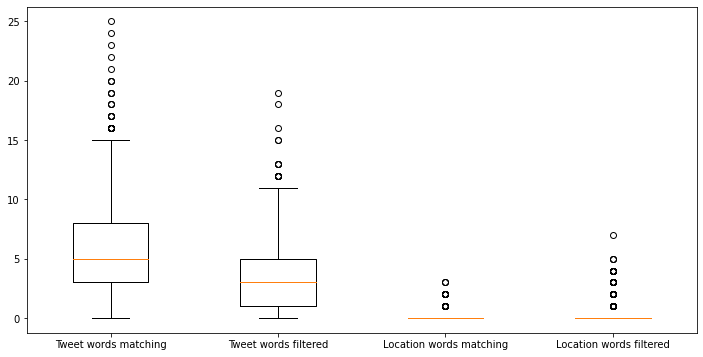

In [ ]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)
ax.boxplot([correct_tweet_vocab_counts, correct_tweet_stop_counts, correct_loc_vocab_counts, correct_loc_stop_counts], labels=("Tweet words matching", "Tweet words filtered", "Location words matching", "Location words filtered"));


In [ ]:
"rt" in train_quality_words

True

In [32]:
# Print how many words were in the vocabulary
# By train set
print(num_matching_words(x_test_std, false_positives, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_vocab, verbose=True, spam_count_dict=spam_words_train, quality_count_dict=quality_words_train))


Document contents:
"I'd rather regret the things that I have done than the things that I have not done." Lucille Ball *Please RT* #Quotes

Pattern found the following words:
['rather', 'regret', 'the', 'things', 'that', 'have', 'done', 'than', 'the', 'things', 'that', 'have', 'not', 'done', 'lucille', 'ball', 'please', 'rt', 'quotes']

{'things', 'have', 'the', 'that', 'done', 'than', 'please', 'rt', 'not'}
9 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'the': (260.9058666507906, 299.7624592381612), 'things': (6.8564256828742, 16.571443381296096), 'that': (68.63253570664779, 102.01935203735736), 'have': (38.31646485869776, 71.874853499778), 'done': (6.6568809969025935, 14.991105700666333), 'than': (21.13976499039857, 22.320352413703183), 'not': (62.21493575441061, 62.440682626597344), 'please': (6.773441940713124, 34.079485237899625), 'rt': (85.44246310742092, 17.93140831178966)}
Document contents:
Gm to you too and everything is g

In [34]:
# Print how many words were in the vocabulary
# By test set
print(num_matching_words(x_test_std, false_positives, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_vocab, verbose=True, spam_count_dict=spam_words_test, quality_count_dict=quality_words_test))


Document contents:
"I'd rather regret the things that I have done than the things that I have not done." Lucille Ball *Please RT* #Quotes

Pattern found the following words:
['rather', 'regret', 'the', 'things', 'that', 'have', 'done', 'than', 'the', 'things', 'that', 'have', 'not', 'done', 'lucille', 'ball', 'please', 'rt', 'quotes']

{'things', 'have', 'the', 'that', 'done', 'than', 'please', 'rt', 'not'}
9 words from the document were found in the vocabulary.

The following words were in the vocabulary: {'the': (6.110368186776036, 12.165303427059706), 'things': (0.747211184092638, 3.877678894071639), 'that': (16.45862108610469, 19.935999871481364), 'have': (6.4865592902642435, 13.485463962797821), 'done': (1.5899386140899687, 2.8727846486854167), 'than': (4.546341478381851, 2.8490388255564025), 'not': (15.021312275484407, 11.615585011732477), 'please': (1.8308394645602792, 6.490497111178052), 'rt': (11.526384895388725, 3.366017771732991)}
Document contents:
Gm to you too and everyth

In [ ]:
print(num_matching_words(x_test_std, false_positives, "Tweet", '(?u)\\b\\w\\w+\\b', tweet_stop, verbose=True))


Document contents:
"I'd rather regret the things that I have done than the things that I have not done." Lucille Ball *Please RT* #Quotes

Pattern found the following words:
['rather', 'regret', 'the', 'things', 'that', 'have', 'done', 'than', 'the', 'things', 'that', 'have', 'not', 'done', 'lucille', 'ball', 'please', 'rt', 'quotes']

{'quotes', 'regret', 'rather', 'ball'}
4 words from the document were found in the vocabulary.

Document contents:
Gm to you too and everything is going well for me. Hbu?

Pattern found the following words:
['gm', 'to', 'you', 'too', 'and', 'everything', 'is', 'going', 'well', 'for', 'me', 'hbu']

{'gm', 'everything', 'well'}
3 words from the document were found in the vocabulary.

Document contents:
$LUV - Creative Planning Has $5,572,000 Stake in Southwest Airlines Co #LUV http://goo.gl/fb/HXAOXL

Pattern found the following words:
['luv', 'creative', 'planning', 'has', '572', '000', 'stake', 'in', 'southwest', 'airlines', 'co', 'luv', 'http', 'goo', '

In [ ]:
print(num_matching_words(x_test_std, false_positives, "location", '(?u)\\b\\w\\w+\\b', loc_vocab, verbose=True))


Document contents:
United States of America

Pattern found the following words:
['United', 'States', 'of', 'America']

1 words from the document were found in the vocabulary.

Document contents:
I N T E R N A T I O N A L

Pattern found the following words:
[]

0 words from the document were found in the vocabulary.

Document contents:


Pattern found the following words:
[]

0 words from the document were found in the vocabulary.

Document contents:
United States, Michigan

Pattern found the following words:
['United', 'States', 'Michigan']

0 words from the document were found in the vocabulary.

Document contents:


Pattern found the following words:
[]

0 words from the document were found in the vocabulary.

Document contents:
Cincinnati, OH

Pattern found the following words:
['Cincinnati', 'OH']

0 words from the document were found in the vocabulary.

Document contents:
west baltimore | zone 7

Pattern found the following words:
['west', 'baltimore', 'zone']

0 words from the do

In [ ]:
print(num_matching_words(x_test_std, false_positives, "location", '(?u)\\b\\w\\w+\\b', loc_stop, verbose=True))

Document contents:
United States of America

Pattern found the following words:
['United', 'States', 'of', 'America']

0 words from the document were found in the vocabulary.

Document contents:
I N T E R N A T I O N A L

Pattern found the following words:
[]

0 words from the document were found in the vocabulary.

Document contents:


Pattern found the following words:
[]

0 words from the document were found in the vocabulary.

Document contents:
United States, Michigan

Pattern found the following words:
['United', 'States', 'Michigan']

0 words from the document were found in the vocabulary.

Document contents:


Pattern found the following words:
[]

0 words from the document were found in the vocabulary.

Document contents:
Cincinnati, OH

Pattern found the following words:
['Cincinnati', 'OH']

0 words from the document were found in the vocabulary.

Document contents:
west baltimore | zone 7

Pattern found the following words:
['west', 'baltimore', 'zone']

3 words from the do

### Full CountVectorizer (non-TF-IDF)

In [ ]:
full_cnt = ColumnTransformer([
            ('tweet', CountVectorizer(), 'Tweet'),
            ('location', CountVectorizer(), 'location')
        ], remainder='passthrough')

x_train_full = full_cnt.fit_transform(x_train_std)

word, spam, quality = find_words_sum(full_cnt, x_train_full, y_train)

In [ ]:
sorted_words = sorted(word.items(), key=operator.itemgetter(1))

In [ ]:
pprint(sorted_words)

[('0000002987', 1.0),
 ('004890', 1.0),
 ('00am', 1.0),
 ('00ko0gxyyl', 1.0),
 ('012798800', 1.0),
 ('014', 1.0),
 ('0151', 1.0),
 ('01828ac0426398', 1.0),
 ('01b3evfrxh', 1.0),
 ('01eoj0tdwy', 1.0),
 ('02067c9642da85', 1.0),
 ('033temuxwj', 1.0),
 ('0399539530', 1.0),
 ('041', 1.0),
 ('04am', 1.0),
 ('04pm', 1.0),
 ('051316', 1.0),
 ('0600', 1.0),
 ('065193', 1.0),
 ('06ksda3iwj', 1.0),
 ('071011', 1.0),
 ('083blqi0um', 1.0),
 ('08nphwx7gs', 1.0),
 ('08rknaux3p', 1.0),
 ('09', 1.0),
 ('099689236010', 1.0),
 ('09ghbuodlb', 1.0),
 ('09yxlxtmuv', 1.0),
 ('0a55unhswi', 1.0),
 ('0ame3udh0z', 1.0),
 ('0ar0t54tjb', 1.0),
 ('0as8mvllrv', 1.0),
 ('0awhghhk66', 1.0),
 ('0bfq4z10wu', 1.0),
 ('0bi0ti9tdq', 1.0),
 ('0c5gezndqo', 1.0),
 ('0cc47a0d1605', 1.0),
 ('0cef24g8s6', 1.0),
 ('0cyt2utesv', 1.0),
 ('0d74', 1.0),
 ('0dgji81vsd', 1.0),
 ('0djxpqoxxb', 1.0),
 ('0e7haglgzk', 1.0),
 ('0eb4hss9cm', 1.0),
 ('0ekowjyt4t', 1.0),
 ('0eor2m7tep', 1.0),
 ('0evhq7t9qp', 1.0),
 ('0gloybzbmm', 1.0),
 ('0gnh

In [ ]:
sorted_spam, sorted_quality = sort_spam_quality(spam, quality)

In [ ]:
pprint(sorted_quality)

[('00ko0gxyyl', 0.00023153507756425097),
 ('01b3evfrxh', 0.00023153507756425097),
 ('01eoj0tdwy', 0.00023153507756425097),
 ('03', 0.00023153507756425097),
 ('06', 0.00023153507756425097),
 ('0600', 0.00023153507756425097),
 ('06ksda3iwj', 0.00023153507756425097),
 ('08rknaux3p', 0.00023153507756425097),
 ('09ghbuodlb', 0.00023153507756425097),
 ('09yxlxtmuv', 0.00023153507756425097),
 ('0ame3udh0z', 0.00023153507756425097),
 ('0ar0t54tjb', 0.00023153507756425097),
 ('0awhghhk66', 0.00023153507756425097),
 ('0bfq4z10wu', 0.00023153507756425097),
 ('0bi0ti9tdq', 0.00023153507756425097),
 ('0c5gezndqo', 0.00023153507756425097),
 ('0cef24g8s6', 0.00023153507756425097),
 ('0cyt2utesv', 0.00023153507756425097),
 ('0dgji81vsd', 0.00023153507756425097),
 ('0djxpqoxxb', 0.00023153507756425097),
 ('0eb4hss9cm', 0.00023153507756425097),
 ('0ekowjyt4t', 0.00023153507756425097),
 ('0evhq7t9qp', 0.00023153507756425097),
 ('0gloybzbmm', 0.00023153507756425097),
 ('0gnh0lu5jm', 0.00023153507756425097

In [ ]:
pprint(sorted_spam)

[('0000002987', 0.0002151462994836489),
 ('004890', 0.0002151462994836489),
 ('00am', 0.0002151462994836489),
 ('01', 0.0002151462994836489),
 ('012798800', 0.0002151462994836489),
 ('014', 0.0002151462994836489),
 ('0151', 0.0002151462994836489),
 ('01828ac0426398', 0.0002151462994836489),
 ('02067c9642da85', 0.0002151462994836489),
 ('033temuxwj', 0.0002151462994836489),
 ('0399539530', 0.0002151462994836489),
 ('041', 0.0002151462994836489),
 ('04am', 0.0002151462994836489),
 ('04pm', 0.0002151462994836489),
 ('051316', 0.0002151462994836489),
 ('065193', 0.0002151462994836489),
 ('071011', 0.0002151462994836489),
 ('08', 0.0002151462994836489),
 ('083blqi0um', 0.0002151462994836489),
 ('08nphwx7gs', 0.0002151462994836489),
 ('09', 0.0002151462994836489),
 ('099689236010', 0.0002151462994836489),
 ('0a55unhswi', 0.0002151462994836489),
 ('0as8mvllrv', 0.0002151462994836489),
 ('0cc47a0d1605', 0.0002151462994836489),
 ('0d74', 0.0002151462994836489),
 ('0e7haglgzk', 0.000215146299483

### Checking what a full TF-IDF looks like

In [ ]:
full_tfidf = ColumnTransformer([
            ('tweet', TfidfVectorizer(), 'Tweet'),
            ('location', TfidfVectorizer(), 'location')
        ], remainder='passthrough')

x_train_full = full_tfidf.fit_transform(x_train_std)

word, spam, quality = find_words_mean(full_tfidf, x_train_full, y_train)

In [ ]:
sorted_words = sorted(word.items(), key=operator.itemgetter(1))

In [ ]:
pprint(sorted_words)

[('ro23452819_w900_h1405', 9.03285057827092e-06),
 ('ro34701216_w900_h1405', 9.03285057827092e-06),
 ('ro48315832_w900_h1405', 9.03285057827092e-06),
 ('ro72387215_w900_h1405', 9.03285057827092e-06),
 ('z7xyo23h53', 9.03285057827092e-06),
 ('ac360', 1.2159344813244587e-05),
 ('bencnn', 1.2159344813244587e-05),
 ('brianstelter', 1.2159344813244587e-05),
 ('cnni', 1.2159344813244587e-05),
 ('cnnsitroom', 1.2159344813244587e-05),
 ('donlemon', 1.2159344813244587e-05),
 ('theleadcnn', 1.2159344813244587e-05),
 ('vanjones68', 1.2159344813244587e-05),
 ('wolfblitzer', 1.2159344813244587e-05),
 ('21s7v6kedd', 1.4451910844529774e-05),
 ('cycleenfield', 1.4451910844529774e-05),
 ('enfieldcouncilpic', 1.4451910844529774e-05),
 ('parikiaki', 1.4451910844529774e-05),
 ('19255', 1.4723168963197328e-05),
 ('26campid', 1.4723168963197328e-05),
 ('26customid', 1.4723168963197328e-05),
 ('26item', 1.4723168963197328e-05),
 ('26lgeo', 1.4723168963197328e-05),
 ('26toolid', 1.4723168963197328e-05),
 ('26

In [ ]:
full_words = [word.replace("tweet__", "").replace("location__", "") for word in full_tfidf.get_feature_names_out()][:-4]

In [ ]:
model_words = [word.replace("tweet__", "").replace("location__", "") for word in tfidf.get_feature_names_out()][:-4]

In [ ]:
print(len(full_words))
print(len(model_words))

30771
312


In [ ]:
print(len(spam))

16629


In [ ]:
print(len(quality))

18425


### t-SNE plot

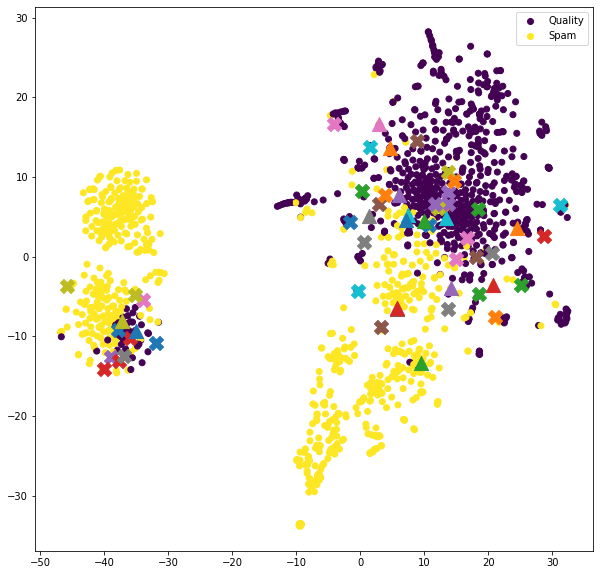

In [ ]:
tsne_embeds = TSNE(random_state=314).fit_transform(x_test_tfidf)
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(tsne_embeds[:,0], tsne_embeds[:,1], label=svm.predict(x_test_tfidf), c=[0 if label == "Quality" else 1 for label in svm.predict(x_test_tfidf)], cmap='viridis')
for idx in false_negatives:
    # ax.scatter(tsne_embeds[idx,0], tsne_embeds[idx,1], s=200, marker="X")
for idx in false_positives:
    ax.scatter(tsne_embeds[idx,0], tsne_embeds[idx,1], s=200, marker="^")
legend = ax.legend(*scatter.legend_elements())
legend.get_texts()[0].set_text("Quality")
legend.get_texts()[1].set_text("Spam")

### Graveyard of code

In [87]:
# First, pull out the top N words
top_n_qual_words_test = [word_tuple[0] for word_tuple in sorted_quality_test_words[-10:]]
top_n_spam_words_test = [word_tuple[0] for word_tuple in sorted_spam_test_words[-10:]]

qual_in_spam_test = {word: spam_words_test[word] for word in top_n_qual_words_test}
spam_in_qual_test = {word: quality_words_test[word] for word in top_n_spam_words_test}
print("Test set top 10 quality words in spam freq:")
pprint(qual_in_spam_test)
print("Test set top 10 spam words in quality freq:")
pprint(spam_in_qual_test)

Test set top 10 quality words in spam freq:
{'and': 0.03739911084040622,
 'com': -1,
 'http': 0.016979930061429543,
 'in': 0.06437222099697334,
 'me': 0.005305585489432269,
 'pic': -1,
 'status': -1,
 'the': 0.06475351760762177,
 'to': 0.06622566629724427,
 'twitter': 0.0008113166971216565}
Test set top 10 spam words in quality freq:
{'and': 0.03849773205539909,
 'co': 0.004587539854869006,
 'for': 0.030772401046714658,
 'https': 0.020104096472396728,
 'in': 0.03884108233015994,
 'news': 0.003380375677917865,
 'of': 0.036776407402305054,
 'the': 0.0817937561135998,
 'to': 0.05827502592498553,
 'trump': 0.0017102000747748892}


In [ ]:
# First, pull out the top N words
top_n_qual_words_train = [word_tuple[0] for word_tuple in sorted_quality_train_words[-10:]]
top_n_spam_words_train = [word_tuple[0] for word_tuple in sorted_spam_train_words[-10:]]
print(top_n_qual_words_train)
print(top_n_spam_words_train)

qual_in_spam_train = {word: spam_words_train[word] for word in top_n_qual_words_train}
spam_in_qual_train = {word: quality_words_train[word] for word in top_n_spam_words_train}
print(qual_in_spam_train)
print(spam_in_qual_train)

In [ ]:
# I am trying to pull out the word's frequency 
pprint([word for word in sorted_quality_test_words])
print()
pprint(sorted_spam_test_words[0:10])

In [46]:
print(quality_words["co"])
print(quality_words["https"])
print(quality_words["in"])
print(quality_words["the"])
print(quality_words["feel"])


0.0031460896354613666
0.02545314236716034
0.03425298905698436
0.06449278382920845
0.005145708805152213
